## Load XAI maps and human maps

In [334]:
import pandas as pd
import os

xai_df = pd.read_pickle("1_all_xai_maps.pickle").reset_index()
human_df = pd.read_pickle("../human_attribution_maps/3_combined_masks.pickle")

# add filename column to xai df
xai_df['filename'] = [os.path.basename(path) for path in xai_df['img_path']]

# only keep XAI maps where human one is available
xai_df = xai_df[xai_df['filename'].isin(list(human_df['filename']))]

xai_df = xai_df[ ['filename'] + [ col for col in xai_df.columns if col != 'filename' ] ] # rearrange columns
xai_df.head(1)


,filename,index,img_path,caption,foil,linguistic_phenomena,model_shap_map,n_image_variants,model,model_shap_positive_normalized
1,licking_291.jpg,1,../../VALSE_data/images/swig/licking_291.jpg,A cow licks its fur.,A cow wrinkles its fur.,actions,"[[-0.055763863715583284, 0.022721240122336894,...",172,LXMERT,"[[0.07359886674465907, 0.02998819329604594, 0...."


### Import function: retrieve downsampled human map by filename

In [335]:
#look at dataframe
human_df.head(1)

,filename,img_path,mask_normalized,caption,foil,nr_clicks,linguistic_phenomena,points_clicked,total_clicks,mask_normalized_downsampled
0,000000001584.jpg,../VALSE_data/images/coco2017/000000001584.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","The red, double decker bus is driving past oth...","The red, double decker bus is driving towards ...","[4, 2, 2]",relations,"[(100, 204), (344, 270), (52, 228), (392, 227)...",8,"[[0.0, 0.0, 0.0, 0.0], [0.041735509019357464, ..."


### Add human maps to XAI DF

In [336]:
from utils import get_human_map_for_filename

human_map_for_row = []
for filename in xai_df['filename']:
    human_map = get_human_map_for_filename(filename)
    human_map_for_row.append(human_map)
xai_df['human_map'] = human_map_for_row

xai_df.to_pickle('1_all_xai_maps_with_human.pickle')

## Define functions: comparison metrics

In [337]:
!pip3 install POT
import ot
import numpy as np

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


### Define function to keep only top n SHAP cells (unused)

This is to facilitate making SHAPs more comparable to human maps

In [338]:
def keep_only_top_shap_patches(shap_map, n=6):
    """Set all but top n elements of 4x4 array to 0
    then normalize (renormalize)"""

    flat_array = shap_map.flatten()
    indices = np.argsort(shap_map)
    # set all but top n to 0
    flat_array[indices[:-n]] = 0
    # renormalize

    flat_array /= flat_array.sum()
    # shape back to 4x4 and return this
    return flat_array.reshape(4, 4)


### Define EMD

Create Euclidian distance matrix to calculate EMD
We will FLATTEN the 2d matrices but this will preserve distance information

These will be the positions of each element in the flattened arrays (checks out):



In [339]:
X, Y = np.meshgrid(np.arange(4), np.arange(4))
positions = np.vstack([Y.ravel(), X.ravel()]).T
print([list(position) for position in positions])

[[0, 0], [0, 1], [0, 2], [0, 3], [1, 0], [1, 1], [1, 2], [1, 3], [2, 0], [2, 1], [2, 2], [2, 3], [3, 0], [3, 1], [3, 2], [3, 3]]


E.g. 0,0 becomes element 0, (1,1) becomes element 5. 

Calculate distances. Distance between 0,0 and 1,1 should be sqrt(1^2 + 1^2) i.e. sqrt(1). Indeed cost_matrix[0,5] is equal to that

In [340]:
cost_matrix = ot.dist(positions, positions, metric='euclidean')
cost_matrix[0,5]

1.4142135623730951

In [341]:
def EMD(map1, map2):
    """Calculate 2-dimensional EMD between
    two 4x4 numpy arrays."""

    # This approach will flatten the arrays, but also use an elementwise distance matrix to preserve information about location
    map1_flattened, map2_flattened = map1.ravel(), map2.ravel()

    # if replace values with rank

    emd_distance = ot.emd2(map1_flattened, map2_flattened, cost_matrix)

    return emd_distance

In [342]:
def scramble_map(array_2d):
    """Scramble the elements of a 4x4 array
    
    Useful for baseline comparison"""

    flat_array = array_2d.flatten()  #  2D array to 1D array
    np.random.shuffle(flat_array)  # shuffle the 1D array in-place
    shuffled = flat_array.reshape((4,4))
    return shuffled

Test EMD:

In [343]:
idx = 7
xai_map = xai_df['model_shap_positive_normalized'][idx]
filename = xai_df['filename'][idx]
human_map = get_human_map_for_filename(filename)
EMD(xai_map, human_map)

0.5229774728003149

### Define rank correlation

In [344]:
import numpy as np
from scipy.stats import spearmanr

def rank_correlation(map1, map2, verbose = False):
    flat1, flat2 = map1.ravel(), map2.ravel()
    if verbose:
        print("Flattened maps:")
        print(flat1)
        print(flat2)
    correlation, p = spearmanr(flat1, flat2)
    return correlation, p

In [345]:
rank_correlation(xai_map, human_map, verbose = True)

Flattened maps:
[0.02274561 0.00081273 0.16827043 0.10578211 0.07308034 0.07541956
 0.03931807 0.02426055 0.00672422 0.04868677 0.08948553 0.1950906
 0.04415409 0.04023031 0.03920289 0.02673618]
[0.01159899 0.03892892 0.02800965 0.01833805 0.0491413  0.11411621
 0.13081067 0.12122488 0.05475923 0.12743874 0.12654352 0.08700085
 0.01944582 0.03701771 0.02538835 0.01023711]


(0.15294117647058825, 0.5717446192454616)

Here we prove that after transposing both the RC does not change

In [346]:
# with transposed
rank_correlation(xai_map.T, human_map.T) == rank_correlation(xai_map, human_map)

True

### Define Chi Squared

In [347]:
from scipy.stats import chisquare

def chi_square(xai_map, human_map):
    xai_flat, human_flat = xai_map.ravel(), human_map.ravel()
    chi2, p = chisquare(xai_flat, human_flat)
    return chi2

chi_square(human_map, xai_map)
    

3.185299998919225

### Define Kullback-Leibler Divergence (relative entropy)

In [348]:
from scipy.stats import entropy

def kld(xai_map, human_map):
    """Kullback-Leibler Divergence for flattend probability distributions"""
    xai_flat, human_flat = xai_map.ravel(), human_map.ravel() #these should already be normalized
    kld = entropy(xai_flat, human_flat)
    return kld

kld(xai_map.T, human_map.T)

0.5585763700954596

This is *unsuitable* because it goes to infinity

# Calculate metrics for each XAI map

- shuffled = whole list of human maps is shuffled, each map is kept intact
- scrambled = each map is kept in place but scrambled, its actual elements are shuffled around

In [349]:
xai_df['shuffled_column_human_map'] = np.random.shuffle(list(xai_df['human_map']))


In [350]:
np.random.shuffle(list(xai_df['human_map']))

In [351]:
from collections import defaultdict

# shuffle column of human maps
shuffled_order_human_maps = np.array(list(xai_df['human_map']))
np.random.shuffle(shuffled_order_human_maps)
# create shuffled human map column which just SHUFFLES all the human maps while keeping each map intact

xai_df['shuffled_column_human_map'] = list(shuffled_order_human_maps)

output_dict = defaultdict(list)
# define baseline normalized FLAT array containing no information (for comparison)
# flat_array = np.full((4,4),1/16)

# loop through dataframe of XAI maps and calculate distance metrics for each
for _, row in xai_df.iterrows():
    filename = row['filename']
    xai_map_unnormalized = row['model_shap_map']

    xai_map = row['model_shap_positive_normalized']
    human_map = row['human_map']
    scrambled_human = scramble_map(human_map)
    human_map_after_shuffle = row['shuffled_column_human_map']

    try:
        # calcualte and append two distance metrics
        output_dict['EMD_to_human'].append(EMD(xai_map, human_map)) #distance to human
        output_dict['RC_to_human'].append(rank_correlation(xai_map, human_map)[0])

        # calculate distance to SCRAMBLED human map
        output_dict['EMD_to_scrambled_human'].append(EMD(xai_map, scrambled_human)) #distance to flat distribution baseline
        output_dict['RC_to_scrambled_human'].append(rank_correlation(xai_map, scrambled_human)[0])


        # calcualte distance to random OTHER human map after order of human maps shuffled in shuffled column
        
        output_dict['EMD_to_shuffled_column_human'].append(EMD(xai_map, human_map_after_shuffle))
        output_dict['RC_to_shuffled_column_human'].append(rank_correlation(xai_map, human_map_after_shuffle)[0])




    except Exception as e:
        print(f"Could not compare to human map for {filename}, {e}")

# add each list in the dictionary to the datarame
for column_name, column in output_dict.items():
    xai_df[column_name] = column




In [352]:
xai_df.head(1)

,filename,index,img_path,caption,foil,linguistic_phenomena,model_shap_map,n_image_variants,model,model_shap_positive_normalized,human_map,shuffled_column_human_map,EMD_to_human,RC_to_human,EMD_to_scrambled_human,RC_to_scrambled_human,EMD_to_shuffled_column_human,RC_to_shuffled_column_human
1,licking_291.jpg,1,../../VALSE_data/images/swig/licking_291.jpg,A cow licks its fur.,A cow wrinkles its fur.,actions,"[[-0.055763863715583284, 0.022721240122336894,...",172,LXMERT,"[[0.07359886674465907, 0.02998819329604594, 0....","[[0.0014743265527438847, 0.01573516504970489, ...","[[0.002197957601655422, 0.014077928917412092, ...",0.983263,-0.058824,0.72668,0.388235,0.616612,0.391176


# Export

In [353]:
xai_df.to_pickle("2_xai_with_distances.pickle")

# Investigate why EMD might be a bad metric

### Average histogram for CLIP SHAP maps

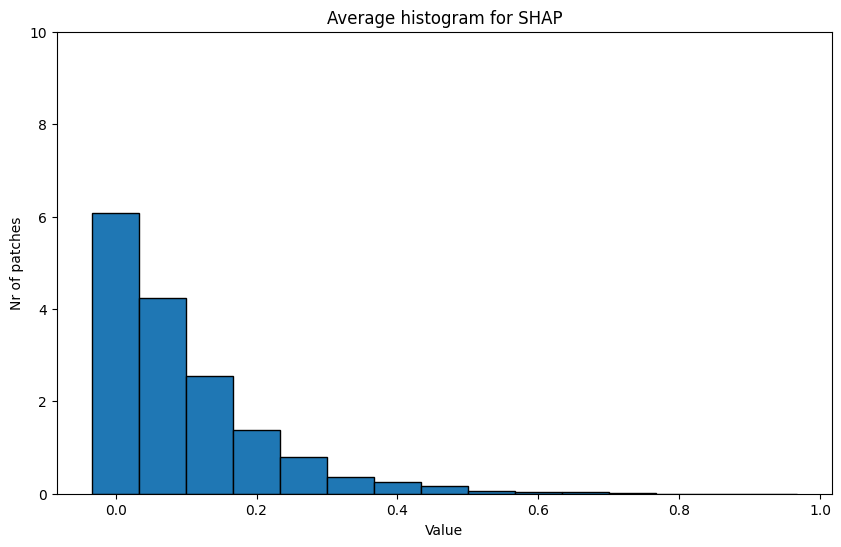

In [354]:
import numpy as np
import matplotlib.pyplot as plt

def avg_mask_histogram(column, title):
    """Average value distribution for all 2d masks in column"""

    num_bins = 15
    sum_histogram = np.zeros(num_bins)

    for mask in column:
        hist, _ = np.histogram(mask, bins=num_bins, range=[0, 0.5])  # adjust range as needed
        # sum histograms
        sum_histogram += hist

    # Compute the average histogram
    average_histogram = sum_histogram / len(column)

    bin_edges = np.linspace(0, 1, len(average_histogram) + 1)  # Adjust 0, 1 to your range

    # Plotting the histogram
    plt.figure(figsize=[10,6])  # Optional: Adjust figure size
    plt.bar(bin_edges[:-1], average_histogram, width=np.diff(bin_edges), edgecolor='black')
    plt.xlabel('Value')  # Adjust as per your histogram variable
    plt.ylabel('Nr of patches')  # Adjust label as necessary
    plt.ylim(0,10)
    plt.title(title)  # Adjust title as necessary
    plt.show()
    return average_histogram

        

xai_hist = avg_mask_histogram(xai_df['model_shap_positive_normalized'], "Average histogram for SHAP")

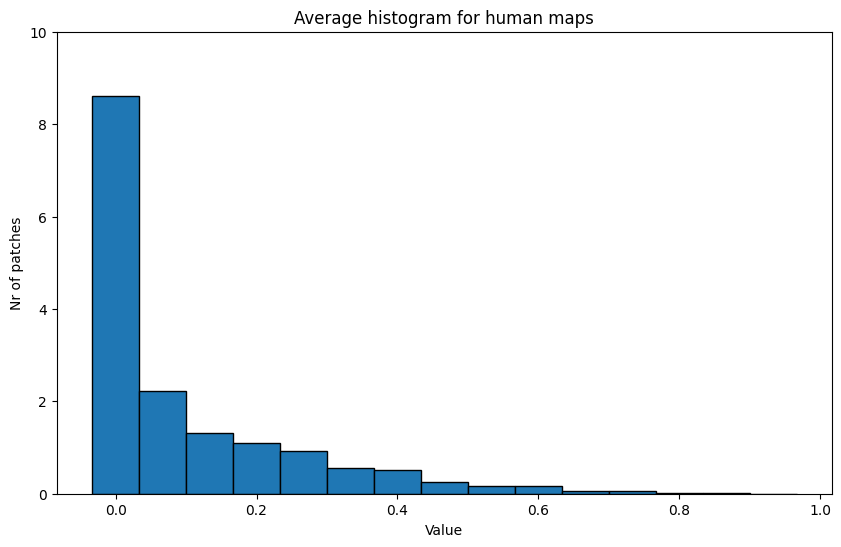

In [355]:
human_hist = avg_mask_histogram(human_df['mask_normalized_downsampled'], "Average histogram for human maps")

### Do CLIP and FLAVA correlate?

In [356]:
clip_xai = xai_df[xai_df['model']=='CLIP'].sort_values(by='filename')
flava_xai = xai_df[xai_df['model']=='FLAVA'].sort_values(by='filename')


In [357]:
rank_correlations = [rank_correlation(clip_map, flava_map)[0] for clip_map, flava_map in zip(list(clip_xai['model_shap_positive_normalized']), list(flava_xai['model_shap_positive_normalized']))]

(array([ 1.,  3.,  6.,  7., 25., 13., 17., 17.,  3.]),
 array([-0.59705882, -0.45130719, -0.30555556, -0.15980392, -0.01405229,
         0.13169935,  0.27745098,  0.42320261,  0.56895425,  0.71470588]),
 <BarContainer object of 9 artists>)

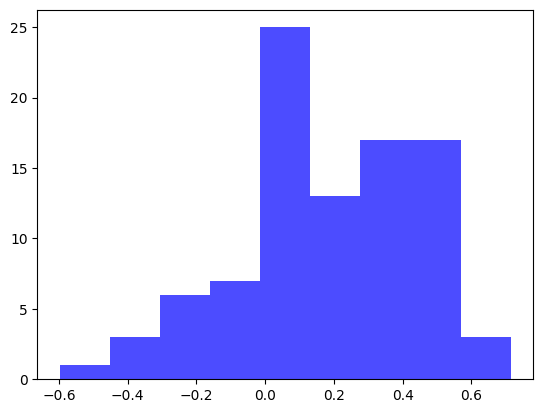

In [358]:
plt.hist(rank_correlations, bins='auto', alpha=0.7, color='blue') 